In [1]:
import numpy as np # https://numpy.org/ja/
import pandas as pd # https://pandas.pydata.org/
from sklearn.model_selection import train_test_split

In [2]:
# 必要な外部パッケージは、以下の内容を編集しインストールしてください
!pip install keras
!pip install opencv-python
# !pip install tensorflow[and-cuda]

In [3]:
class JudgeParticle:

    @staticmethod
    def opening(image, non_zero_thread=4):
        cp = image.copy()
        for y in range(len(image)):
            for x in range(len(image[0])):
                if image[y][x] == 0:
                    continue
                offsets = [ (-1, 0),
                   (0, -1),           (0, 1),
                    (1, 0),
                ]
                values = []
                for offset in offsets:
                    _y = y + offset[0]
                    _x = x + offset[1]
                    if 0 <= _y < len(image) and 0 <= _x < len(image[0]):
                        values.append(image[_y][_x])
                    else:
                        values.append(0)
                if np.count_nonzero(values) <= non_zero_thread:
                    cp[y][x] = 0
                # cp[y][x] = np.count_nonzero(values)
        return cp
        
    @staticmethod
    def closing(image, non_zero_thread=1):
        cp = image.copy()
        for y in range(len(image)):
            for x in range(len(image[0])):
                if image[y][x] != 0:
                    continue
                offsets = [ (-1, 0),
                   (0, -1),           (0, 1),
                    (1, 0),
                ]
                values = []
                for offset in offsets:
                    _y = y + offset[0]
                    _x = x + offset[1]
                    if 0 <= _y < len(image) and 0 <= _x < len(image[0]):
                        values.append(image[_y][_x])
                    else:
                        values.append(0)
                if np.count_nonzero(values) >= non_zero_thread:
                    cp[y][x] = 2
                # cp[y][x] = np.count_nonzero(values)
        return cp

    @staticmethod
    def get_is_Scratch_accuracy(df_row):
        from myLabeling import myLabeling
        import math
        import cv2

        cutting_img = df_row.waferMap.copy()
        cutting_img[cutting_img < 2] = 0
        cutting_particle_cnt = np.count_nonzero(cutting_img)
        erosion_img = cutting_img
        erosion_img = JudgeParticle.opening(erosion_img, 2)
        erosion_particle_cnt = np.count_nonzero(erosion_img)
        rate = erosion_particle_cnt / cutting_particle_cnt
        return rate
        
    @staticmethod
    def is_Scratch(df_row, is_print=True, thread=0.017):
        from myLabeling import myLabeling
        import math
        import cv2

        rate = JudgeParticle.get_is_Scratch_accuracy(df_row)
        if rate <= thread:
            return True
        else:
            return False

def solution(x_test_df, train_df):
    import numpy as np
    from skimage.transform import resize
    from sklearn.svm import SVC
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    from sklearn.neighbors import NearestCentroid

    #画像を共通のサイズにリサイズ
    target_size = (81, 81)
    resized_images = []
    for img in train_df['waferMap']:
        resized_img = resize(img, target_size, anti_aliasing=True)
        resized_images.append(resized_img)

    #NumPy配列に変換
    X_train = np.array(resized_images)
    y_train = np.array(train_df['failureType'])

    #PCA次元削減
    pca = PCA(n_components=350)
    X_train_pca = pca.fit_transform(X_train.reshape(X_train.shape[0], -1))

    # SVM作成と訓練
    svm_model = SVC(kernel='linear', C=80, random_state=100, max_iter=-1)
    svm_model.fit(X_train_pca, y_train)

    #テストデータで予測
    resized_images_test = []
    for img in x_test_df['waferMap']:
        resized_img_test = resize(img, target_size, anti_aliasing=True)
        resized_images_test.append(resized_img_test)

    X_test = np.array(resized_images_test)
    X_test_pca = pca.transform(X_test.reshape(X_test.shape[0], -1))

    y_pred = svm_model.predict(X_test_pca)

    user_result_df = x_test_df.assign(failureType = y_pred)
    
    # DataFrameの内容を一行ずつループして、一部を書き換える
    failureTypes = []
    for row in user_result_df.itertuples():
        if row.failureType == 'Loc' and JudgeParticle.is_Scratch(row):
            failureTypes.append('Scratch')
        else:
            failureTypes.append(row.failureType)
    
    return pd.DataFrame({'failureType': failureTypes}, index=x_test_df.index)

In [4]:
# %%timeit -r 1 -n 1

# データのインポート
df=pd.read_pickle("../input/LSWMD_25519.pkl")

# テスト用と学習用のデータを作成（テストする際は、random_stateの値などを編集してみてください）
train_df, test_df = train_test_split(df, stratify=df['failureType'], test_size=0.10, random_state=42)

y_test_df = test_df[['failureType']]
x_test_df = test_df.drop(columns=['failureType'])

# solution関数を実行
user_result_df = solution(x_test_df, train_df)

average_accuracy = 0
# ユーザーの提出物のフォーマット確認
if type(y_test_df) == type(user_result_df) and y_test_df.shape == user_result_df.shape:
    # 平均精度の計算
    accuracies = {}
    for failure_type in df['failureType'].unique():
        y_test_df_by_failure_type = y_test_df[y_test_df['failureType'] == failure_type]
        user_result_df_by_failure_type = user_result_df[y_test_df['failureType'] == failure_type]
        matching_rows = (y_test_df_by_failure_type == user_result_df_by_failure_type).all(axis=1).sum()
        accuracies[failure_type] = (matching_rows/(len(y_test_df_by_failure_type)))

    average_accuracy = sum(accuracies.values())/len(accuracies)

print(f"平均精度：{average_accuracy*100:.2f}%")

平均精度：80.04%


{'Loc': 0.7743732590529248, 'Edge-Loc': 0.8304431599229287, 'Center': 0.9557109557109557, 'Edge-Ring': 0.96900826446281, 'Scratch': 0.2773109243697479, 'Random': 0.7931034482758621, 'Near-full': 1.0, 'Donut': 0.8035714285714286}


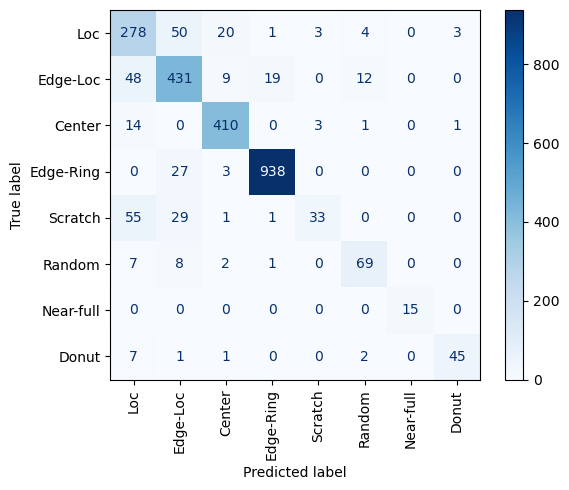

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 参考：https://qiita.com/wakame1367/items/5420ac91702edf993124
# 恐らく、こんな意味↓ ドキュメント見てもよくわからんかった。
# y_pred: 予測したfailureType, y_true: 正解のfailureType
print(accuracies)
labels = df['failureType'].unique()
cm = confusion_matrix(y_pred=user_result_df['failureType'], y_true=y_test_df['failureType'], labels=labels)
# display_labels: 集計して表示するラベル。
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)

cmp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')


In [6]:
#
# 誤分類したものを閲覧する。
#
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt

# 画像の表示関数
def image_show(target_df, y_test_df, x_test_df, user_result_df, x=0): 
    ori_image = x_test_df.waferMap[x]
    true_label = y_test_df.failureType[x]
    result_label = user_result_df.failureType[x]
    print('true label  :', true_label)
    print('result label:', result_label)
    plt.imshow(ori_image)
    plt.show()
    return x

# failureType 選択関数
def select_type(failureType='Loc'): 
    drop_indexes = []
    for index in range(len(user_result_df)):
        true_df = y_test_df.iloc[index]
        result_df = user_result_df.iloc[index]
        if true_df.failureType != failureType:
            drop_indexes.append(true_df.name)
            continue
        if true_df.failureType == result_df.failureType:
            drop_indexes.append(true_df.name)
    filterd_df = x_test_df.drop(index=drop_indexes)
    num_widget = widgets.IntSlider(
        value=0,
        min=0,
        max=len(filterd_df.waferMap) - 1
    )
    interact(image_show,
        x=num_widget,
        target_df=fixed(x_test_df.drop(index=drop_indexes).reset_index()),
        y_test_df=fixed(y_test_df.drop(index=drop_indexes).reset_index()),
        x_test_df=fixed(x_test_df.drop(index=drop_indexes).reset_index()),
        user_result_df=fixed(user_result_df.drop(index=drop_indexes).reset_index()),
    );

labels = y_test_df.failureType.unique() # ラベル取得
interact(select_type, failureType=labels); # failureType選択

interactive(children=(Dropdown(description='failureType', index=2, options=('Edge-Ring', 'Edge-Loc', 'Loc', 'R…